<a href="https://colab.research.google.com/github/RiskiFarhansi/Studi-Penerapan-CatBoost-dalam-Prediksi-Hasil-Pemeriksaan-Kesehatan/blob/main/Studi_Penerapan_CatBoost_dalam_Prediksi_Hasil_Pemeriksaan_Kesehatan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EVALUASI DATA**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# Ganti 'file_path' dengan lokasi dataset Anda
file_path = '/content/paru-paru-prediksi.csv'
df = pd.read_csv(file_path)

In [ ]:
# 1.1. Deskripsi Data
print("=== Deskripsi Data ===")
print(df.info())  # Informasi tipe data dan jumlah non-null
print("\nStatistik Data Kategorikal:")
print(df.describe(include='object'))  # Statistik data kategorikal
print("\nNilai Unik Tiap Kolom:")
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

=== Deskripsi Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   No                  30000 non-null  int64 
 1   Usia                30000 non-null  object
 2   Jenis_Kelamin       30000 non-null  object
 3   Merokok             30000 non-null  object
 4   Bekerja             30000 non-null  object
 5   Rumah_Tangga        30000 non-null  object
 6   Aktivitas_Begadang  30000 non-null  object
 7   Aktivitas_Olahraga  30000 non-null  object
 8   Asuransi            30000 non-null  object
 9   Penyakit_Bawaan     30000 non-null  object
 10  Hasil               30000 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.5+ MB
None

Statistik Data Kategorikal:
         Usia Jenis_Kelamin Merokok Bekerja Rumah_Tangga Aktivitas_Begadang  \
count   30000         30000   30000   30000        30000              30000   
u


Distribusi Target (Hasil):
Hasil
Tidak    15648
Ya       14352
Name: count, dtype: int64


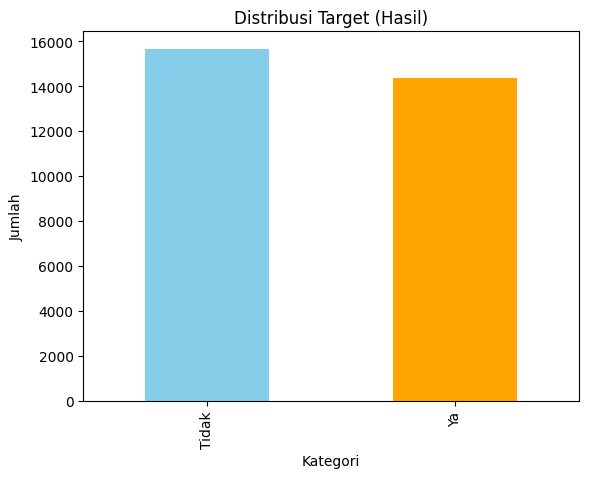

In [ ]:
# Analisis Distribusi Target
print("\nDistribusi Target (Hasil):")
print(df['Hasil'].value_counts())
df['Hasil'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Distribusi Target (Hasil)")
plt.xlabel("Kategori")
plt.ylabel("Jumlah")
plt.show()

In [ ]:
# 1.2. Identifikasi Missing Values
print("\n=== Missing Values ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # Kolom dengan missing values

# Pilihan Imputasi
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(f"\nImputasi untuk kolom {col}:")


=== Missing Values ===
Series([], dtype: int64)


Tidak ada missing value


=== Ketidakseimbangan Target ===
Proporsi Target:
Hasil
Tidak    0.5216
Ya       0.4784
Name: count, dtype: float64


<ipython-input-7-4200b6281ecf>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hasil', data=df, palette='pastel')


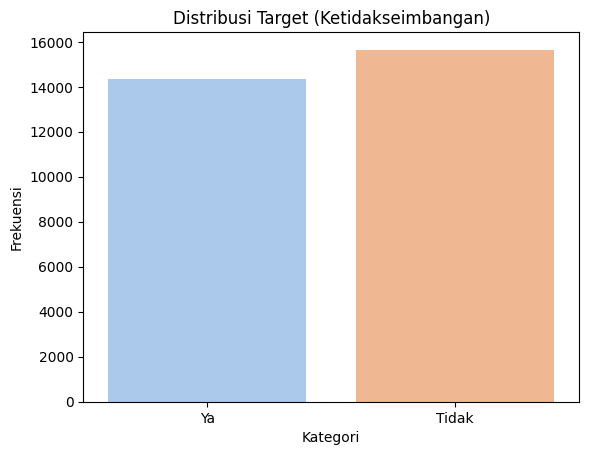

In [ ]:
# 1.3. Deteksi Ketidakseimbangan Target
print("\n=== Ketidakseimbangan Target ===")
total = len(df)
count_target = df['Hasil'].value_counts()
imbalance_ratio = count_target / total
print(f"Proporsi Target:\n{imbalance_ratio}")

# Visualisasi Ketidakseimbangan
sns.countplot(x='Hasil', data=df, palette='pastel')
plt.title("Distribusi Target (Ketidakseimbangan)")
plt.xlabel("Kategori")
plt.ylabel("Frekuensi")
plt.show()

# **PRE-PROCESSING**

In [ ]:
df_processed = df.copy()

In [ ]:
# 2.1. Encoding Target
label_encoder = LabelEncoder()
df_processed['Hasil'] = label_encoder.fit_transform(df_processed['Hasil'])  # Ya=1, Tidak=0

# Encoding semua fitur kategori untuk SMOTE
categorical_features = ['Usia', 'Jenis_Kelamin', 'Merokok', 'Bekerja',
                        'Rumah_Tangga', 'Aktivitas_Begadang', 'Aktivitas_Olahraga',
                        'Asuransi', 'Penyakit_Bawaan']

for col in categorical_features:
    df_processed[col] = label_encoder.fit_transform(df_processed[col])

In [ ]:
# 2.2. Encoding Fitur Kategori untuk CatBoost
# CatBoost dapat langsung bekerja dengan fitur kategori tanpa encoding manual.
# Tentukan fitur kategori
categorical_features = ['Usia', 'Jenis_Kelamin', 'Merokok', 'Bekerja', 'Rumah_Tangga',
                        'Aktivitas_Begadang', 'Aktivitas_Olahraga', 'Asuransi', 'Penyakit_Bawaan']

print("\nFitur kategori yang dikenali CatBoost:")
print(categorical_features)


Fitur kategori yang dikenali CatBoost:
['Usia', 'Jenis_Kelamin', 'Merokok', 'Bekerja', 'Rumah_Tangga', 'Aktivitas_Begadang', 'Aktivitas_Olahraga', 'Asuransi', 'Penyakit_Bawaan']


In [ ]:
# 2.3. Pembagian Data
X = df_processed.drop(['No', 'Hasil'], axis=1)  # Hapus kolom ID dan target
y = df_processed['Hasil']

# Pembagian data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2.4. Menyeimbangkan Data dengan SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nDistribusi Target di Data Train (Setelah SMOTE):")
print(y_train_balanced.value_counts())


Distribusi Target di Data Train (Setelah SMOTE):
Hasil
1    12518
0    12518
Name: count, dtype: int64



Distribusi Target di Data Train (Setelah SMOTE):
Hasil
1    12518
0    12518
Name: count, dtype: int64


<ipython-input-13-1a23fd4e6f01>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_balanced, palette='pastel')


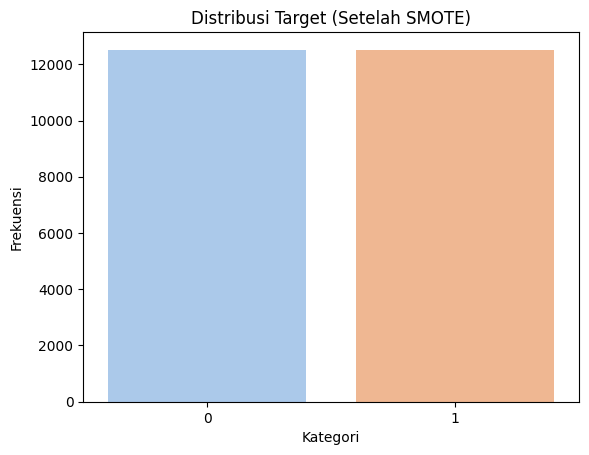

In [ ]:
print("\nDistribusi Target di Data Train (Setelah SMOTE):")
print(y_train_balanced.value_counts())

# Visualisasi distribusi setelah SMOTE
sns.countplot(x=y_train_balanced, palette='pastel')
plt.title("Distribusi Target (Setelah SMOTE)")
plt.xlabel("Kategori")
plt.ylabel("Frekuensi")
plt.show()

# **EDA**

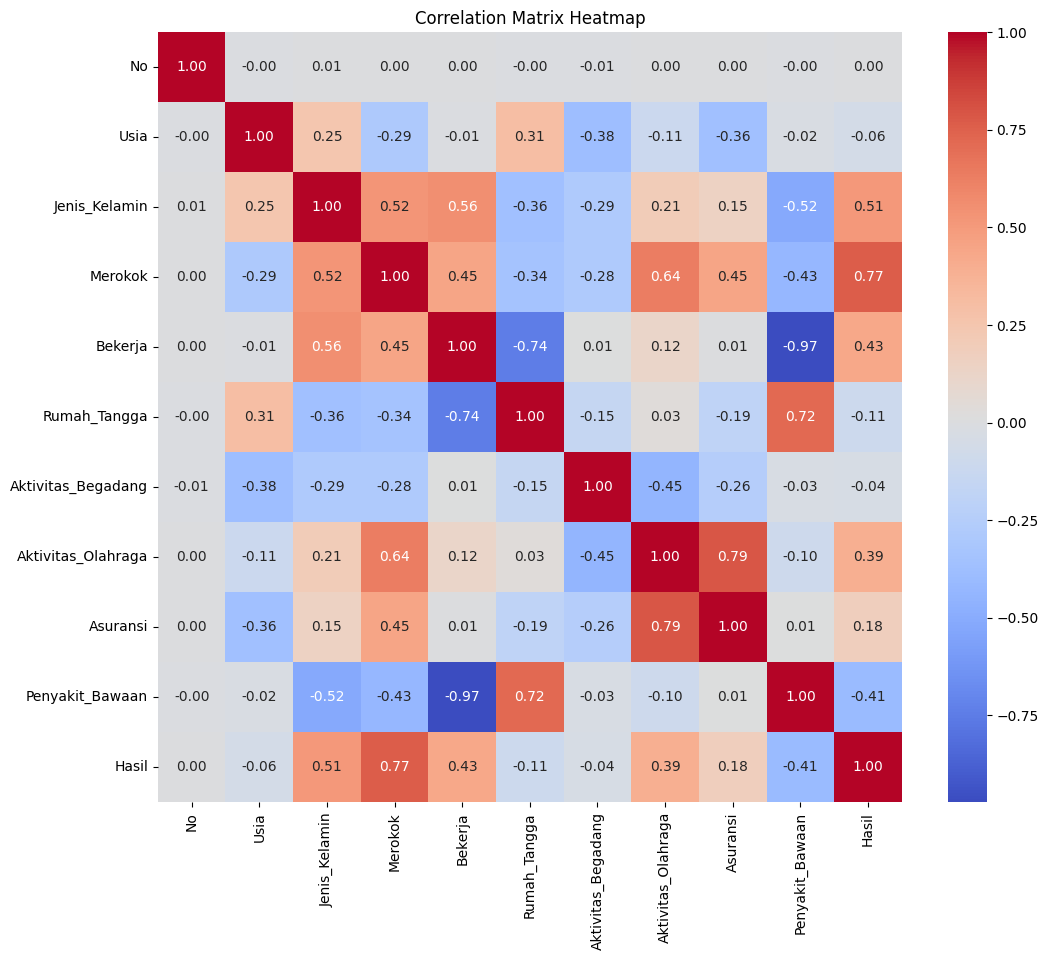

In [ ]:
# Correlation Matrix Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df_processed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# **Ringkasan pembagian dataset**

In [ ]:
print("=== Ringkasan Pembagian Dataset ===")
print(f"Jumlah data keseluruhan: {len(df_processed)}")
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

print("\n=== Distribusi Target pada Data Training ===")
print(y_train.value_counts())

print("\n=== Distribusi Target pada Data Testing ===")
print(y_test.value_counts())

# Tampilkan contoh data training dan testing
print("\n=== Contoh Data Training ===")
print(X_train.head())

print("\n=== Contoh Data Testing ===")
print(X_test.head())

=== Ringkasan Pembagian Dataset ===
Jumlah data keseluruhan: 30000
Jumlah data training: 24000
Jumlah data testing: 6000

=== Distribusi Target pada Data Training ===
Hasil
0    12518
1    11482
Name: count, dtype: int64

=== Distribusi Target pada Data Testing ===
Hasil
0    3130
1    2870
Name: count, dtype: int64

=== Contoh Data Training ===
       Usia  Jenis_Kelamin  Merokok  Bekerja  Rumah_Tangga  \
12413     0              1        1        1             0   
2746      0              1        1        1             0   
15429     0              1        1        1             0   
7192      0              1        1        1             0   
4376      1              1        0        0             1   

       Aktivitas_Begadang  Aktivitas_Olahraga  Asuransi  Penyakit_Bawaan  
12413                   1                   1         1                0  
2746                    1                   0         0                0  
15429                   1                   1         

# **Latih Data dengan CatBoost**

In [ ]:
# 3. Latih Model CatBoost
# Tentukan fitur kategori (CatBoost tetap dapat menangani fitur kategori meskipun telah diencoding untuk SMOTE)
categorical_features = ['Usia', 'Jenis_Kelamin', 'Merokok', 'Bekerja',
                        'Rumah_Tangga', 'Aktivitas_Begadang', 'Aktivitas_Olahraga',
                        'Asuransi', 'Penyakit_Bawaan']

# Inisialisasi model
model = CatBoostClassifier(iterations=500,  # Jumlah iterasi
                           learning_rate=0.1,  # Learning rate
                           depth=6,  # Kedalaman tree
                           cat_features=categorical_features,  # Fitur kategori
                           verbose=50,  # Log setiap 50 iterasi
                           random_seed=42)

# Latih model pada data training yang sudah diimbangi
model.fit(X_train_balanced, y_train_balanced)


0:	learn: 0.4044746	total: 54.5ms	remaining: 27.2s
50:	learn: 0.0827080	total: 299ms	remaining: 2.63s
100:	learn: 0.0824837	total: 504ms	remaining: 1.99s
150:	learn: 0.0824237	total: 744ms	remaining: 1.72s
200:	learn: 0.0824237	total: 1.03s	remaining: 1.53s
250:	learn: 0.0824237	total: 1.28s	remaining: 1.27s
300:	learn: 0.0824237	total: 1.54s	remaining: 1.02s
350:	learn: 0.0824237	total: 1.82s	remaining: 774ms
400:	learn: 0.0824237	total: 2.08s	remaining: 515ms
450:	learn: 0.0824237	total: 2.34s	remaining: 254ms
499:	learn: 0.0824237	total: 2.59s	remaining: 0us



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3130
           1       1.00      0.88      0.94      2870

    accuracy                           0.94      6000
   macro avg       0.95      0.94      0.94      6000
weighted avg       0.95      0.94      0.94      6000


=== Confusion Matrix ===
[[3130    0]
 [ 340 2530]]


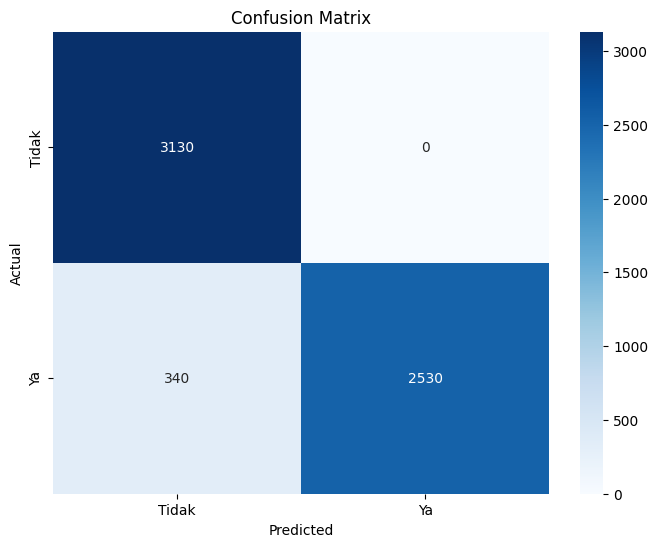


Akurasi Model: 0.94


In [ ]:
# 4. Evaluasi Model
# Prediksi pada data test
y_pred = model.predict(X_test)

# Evaluasi performa
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak', 'Ya'], yticklabels=['Tidak', 'Ya'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi Model: {accuracy:.2f}")


=== Feature Importance ===
           Feature Id  Importances
0             Merokok    49.299158
1        Rumah_Tangga    20.456731
2  Aktivitas_Begadang    10.542685
3     Penyakit_Bawaan     5.100873
4                Usia     3.820843
5             Bekerja     3.774513
6       Jenis_Kelamin     3.204495
7  Aktivitas_Olahraga     2.100529
8            Asuransi     1.700173


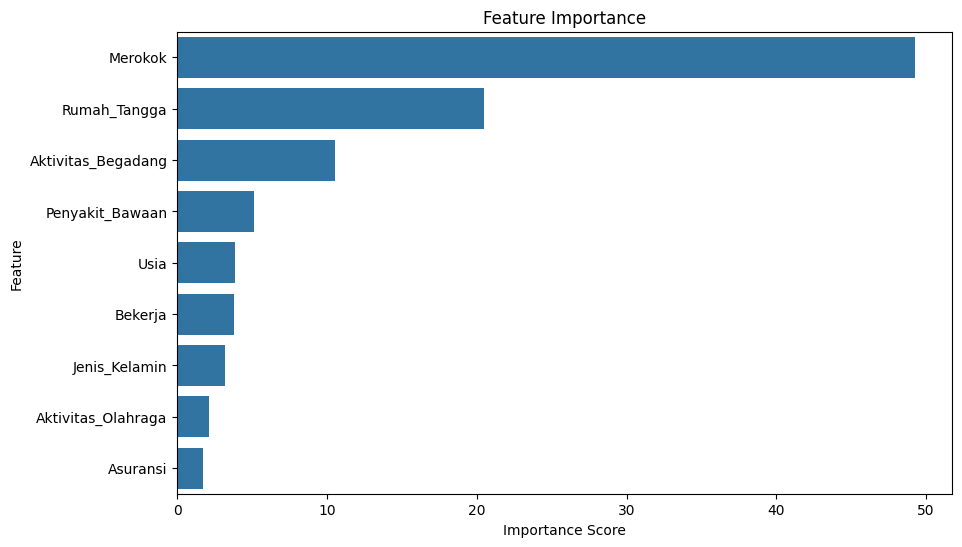

In [ ]:
# prompt: Visualisasi feature importance,Hitung feature importance

# Feature Importance
feature_importance = model.get_feature_importance(prettified=True)
print("\n=== Feature Importance ===")
print(feature_importance)

# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Feature Id', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# **hyperparameter tuning Grid Search**

0:	learn: 0.6598305	total: 14.1ms	remaining: 2.8s
50:	learn: 0.1186401	total: 622ms	remaining: 1.82s
100:	learn: 0.0890971	total: 1.24s	remaining: 1.22s
150:	learn: 0.0852669	total: 1.53s	remaining: 498ms
199:	learn: 0.0842403	total: 1.78s	remaining: 0us
Best Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.01}
Best Score: 0.9440404856637086

=== Classification Report (Tuned Model) ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3130
           1       1.00      0.88      0.94      2870

    accuracy                           0.94      6000
   macro avg       0.95      0.94      0.94      6000
weighted avg       0.95      0.94      0.94      6000


=== Confusion Matrix (Tuned Model) ===
[[3130    0]
 [ 340 2530]]


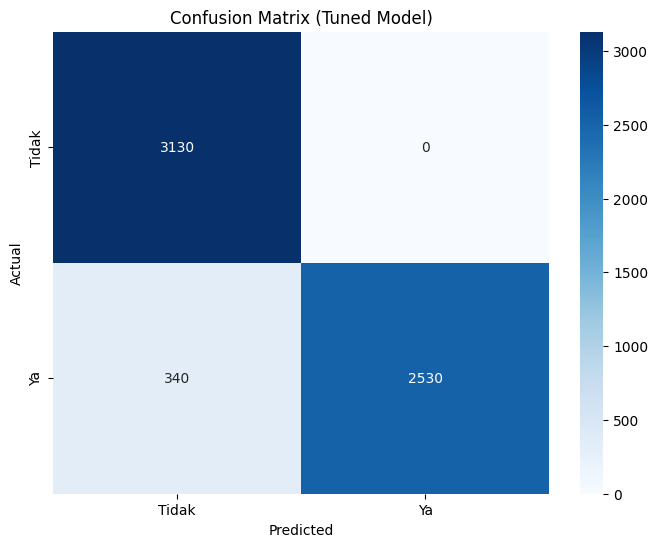


Akurasi Model (Tuned): 0.94


In [ ]:
# prompt: tuningkan secara sederhana saja

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [200, 500],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best model to make predictions on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
print("\n=== Classification Report (Tuned Model) ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix (Tuned Model) ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak', 'Ya'], yticklabels=['Tidak', 'Ya'])
plt.title("Confusion Matrix (Tuned Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi Model (Tuned): {accuracy:.2f}")